# Pembuatan data sintetik kurva cahaya okultasi dengan fungsi Fresnel

Okultasi merupakan peristiwa tertutupnya obyek langit yang memiliki ukuran sudut lebih kecil oleh obyek langit yang memiliki ukuran sudut lebih besar, misalnya okultasi bintang oleh Bulan. Saat Bulan bergerak menutupi sebuah bintang, maka bayangannya akan bergerak di permukaan Bumi dengan kecepatan $v$.

Jika bayangan ini diamati melalui teleskop, maka intensitas bintang yang terdeteksi akan berfluktuasi dan akhirnya hilang saat bintang sepenuhnya tertutup oleh Bulan. Jika kita meninjau pada suatu panjang gelombang tertentu, $\lambda$,  pola intensitas yang terekam, $F(w)$, bisa dianggap sebagai pola intensitas sebuah obyek titik (*point source*) yang dihalangi oleh sebuah tepian lurus dan tajam, dan bisa dideskripsikan dengan integral Fresnel sebagai berikut:

\begin{align}
F(w) = I \times \frac{1}{2} \left[\left(C(w) + \frac{1}{2}\right)^2 + \left(S(w) + \frac{1}{2}\right)^2 \right]
\end{align}

dengan $w$ adalah *Fresnel number*, yang didefinisikan sebagai $w = x\sqrt{\frac{2}{\lambda d}}$, dengan $x$ adalah jarak ke tepian bayangan (di permukaan Bumi), dan $d$ adalah jarak Bumi - Bulan saat okultasi terjadi.

Komponen cosinus dan sinus dari integral Fresnel, $C(w)$ dan $S(w)$, dituliskan sebagai:

\begin{align}
C(w) &= \int_0^w \cos \left( \frac{\pi}{2} t^2 \right) dt \\
S(w) &= \int_0^w \sin \left( \frac{\pi}{2} t^2 \right) dt
\end{align}

## Buat sebuah fungsi untuk integral Fresnel

In [1]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook'])
# import seaborn as sns; sns.set(font_scale=1.5)
import scipy.special
import pandas as pd
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

# plt.style.use('ggplot')
# plt.rcParams['font.family'] = 'Serif'
# plt.rcParams['font.size'] = '16'

In [2]:
def diffract(t, t0, A, v):
    cc, ss = scipy.special.fresnel(v*(t-t0))
    y = A*0.5*((cc + 0.5)**2 + (ss + 0.5)**2)
    # print("cc=", type(cc))
    return y

Fungsi di atas merupakan bentuk lain dari fungsi Fresnel yang di dalamnya mengandung komponen trigonometri `cos` dan `sin`. Parameter $t_0$ merupakan waktu terjadinya peristiwa, yaitu saat intensitas bintang turun menjadi sekitar 25% dari nilainya, $A$ adalah amplitudo dari kurva cahaya (atau $I$ dalam persamaan sebelumnya), dan $v$ adalah kecepatan bayangan Bulan di permukaan Bumi.

Jika divisualisasikan untuk nilai $v$ yang berbeda, dengan asumsi nilai yang lain sama (misal $A = 100, t_0 = 0$) maka diperoleh gambar berikut:

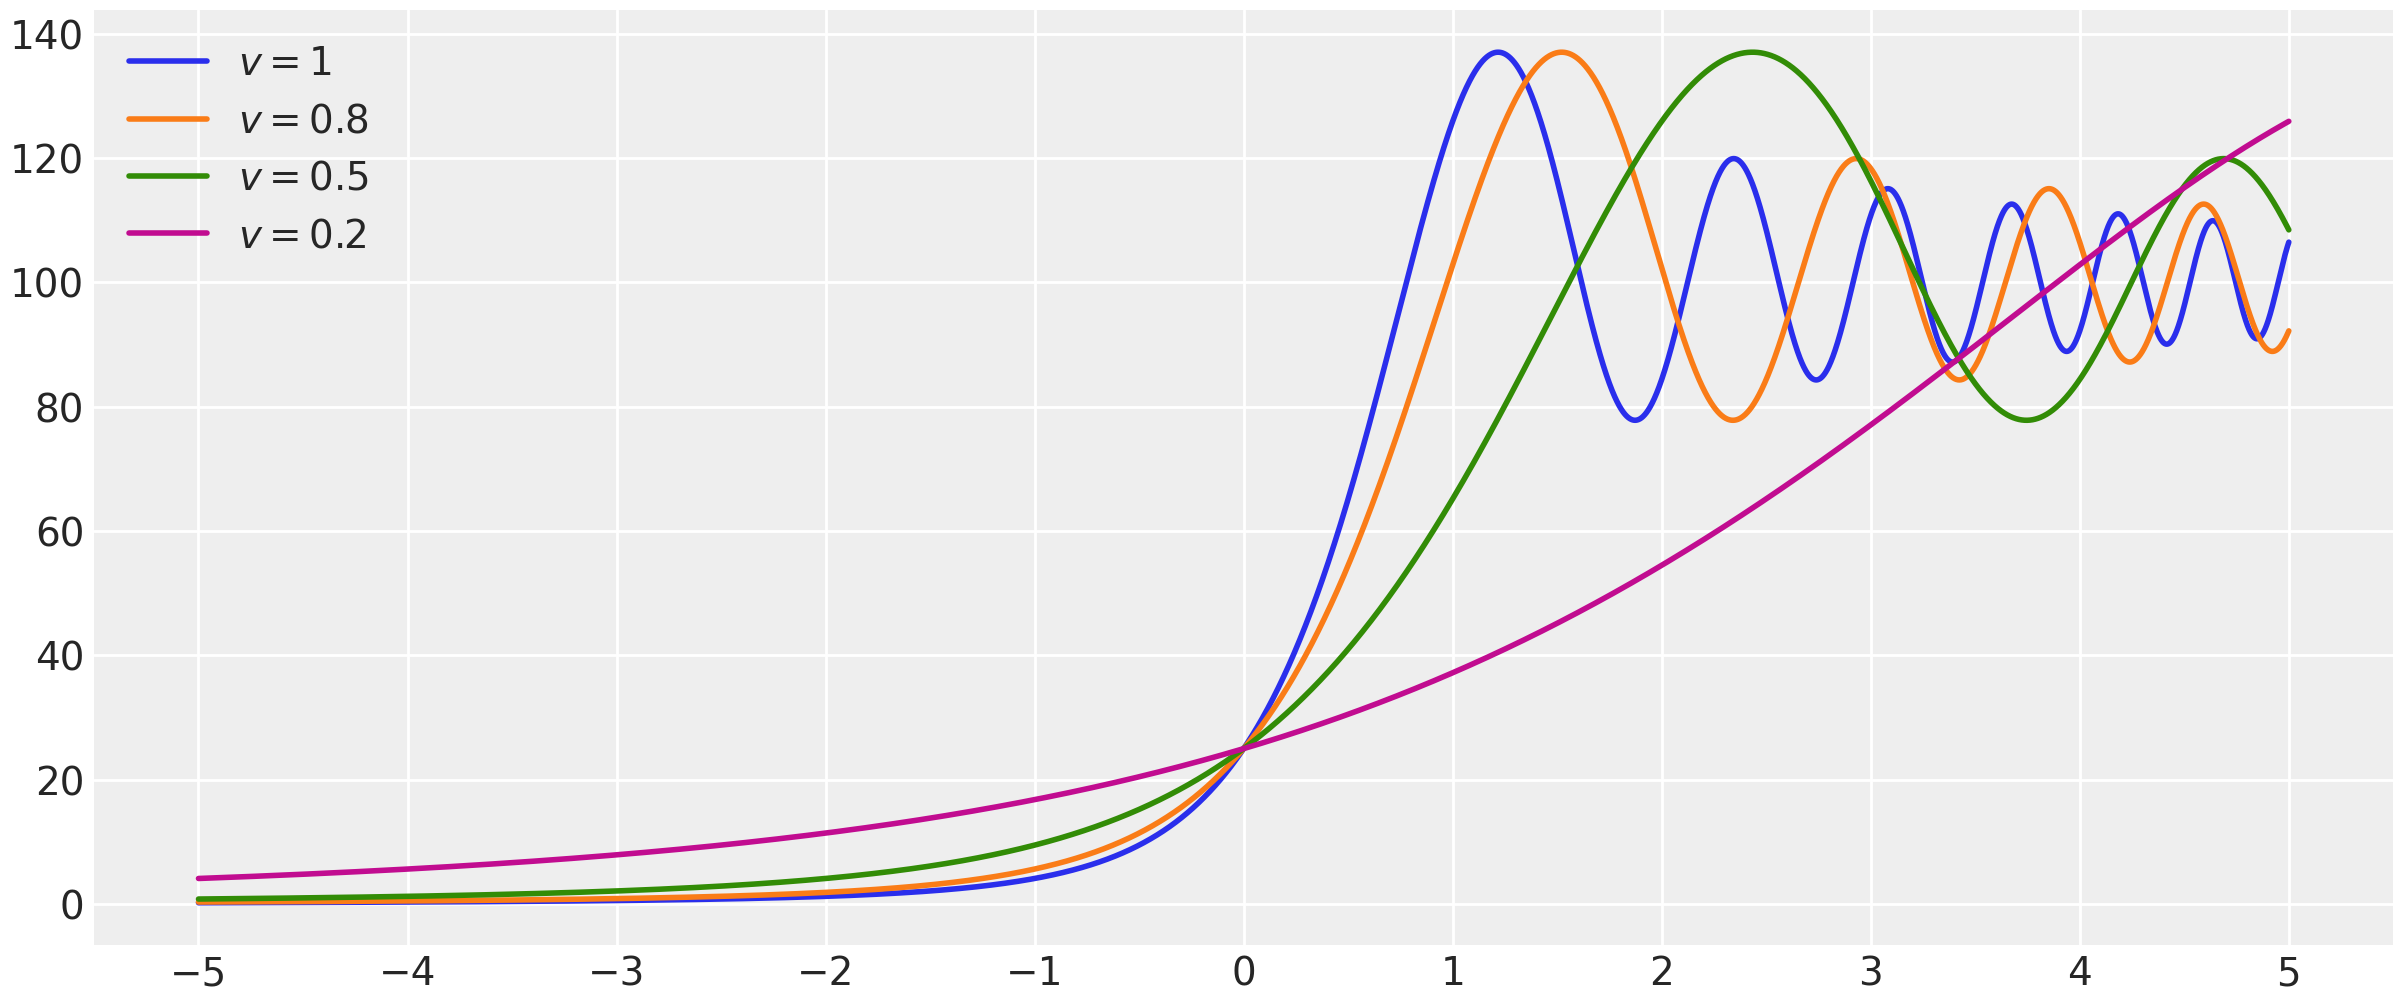

In [3]:
plt.figure(figsize = (12,5), facecolor='w')
nu = np.linspace(-5,5,10000)
# nu=1
plt.plot(nu, diffract(nu, 0, 100, 1))
plt.plot(nu, diffract(nu, 0, 100, 0.8))
plt.plot(nu, diffract(nu, 0, 100, 0.5))
plt.plot(nu, diffract(nu, 0, 100, 0.2))
plt.legend(['$v = 1$','$v = 0.8$', '$v = 0.5$', '$v = 0.2$'])
plt.xticks(np.arange(-5,6));

## Membuat data artifisial yang mengandung *noise*

Asumsikan parameter yang diambil adalah sebagai berikut:
- nilai *noise* adalah $\sigma = 10$
- amplitudo $A = 100$
- kecepatan $v = 1$
- waktu *event* $t_0 = 0$

In [4]:
x_data = np.linspace(-5, 5, 200)
σ_true = 10
A_true = 100
t0_true = 0
v_true = 1

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

y_data = diffract(x_data, t0_true, A_true, v_true)
y_data = rng.normal(y_data, scale=σ_true)

y_data_scaled = y_data / (y_data.std()*2)

A_true_scaled = A_true / (y_data.std()*2)
σ_true_scaled = σ_true / (y_data.std()*2)

Text(0, 0.5, 'Intensity')

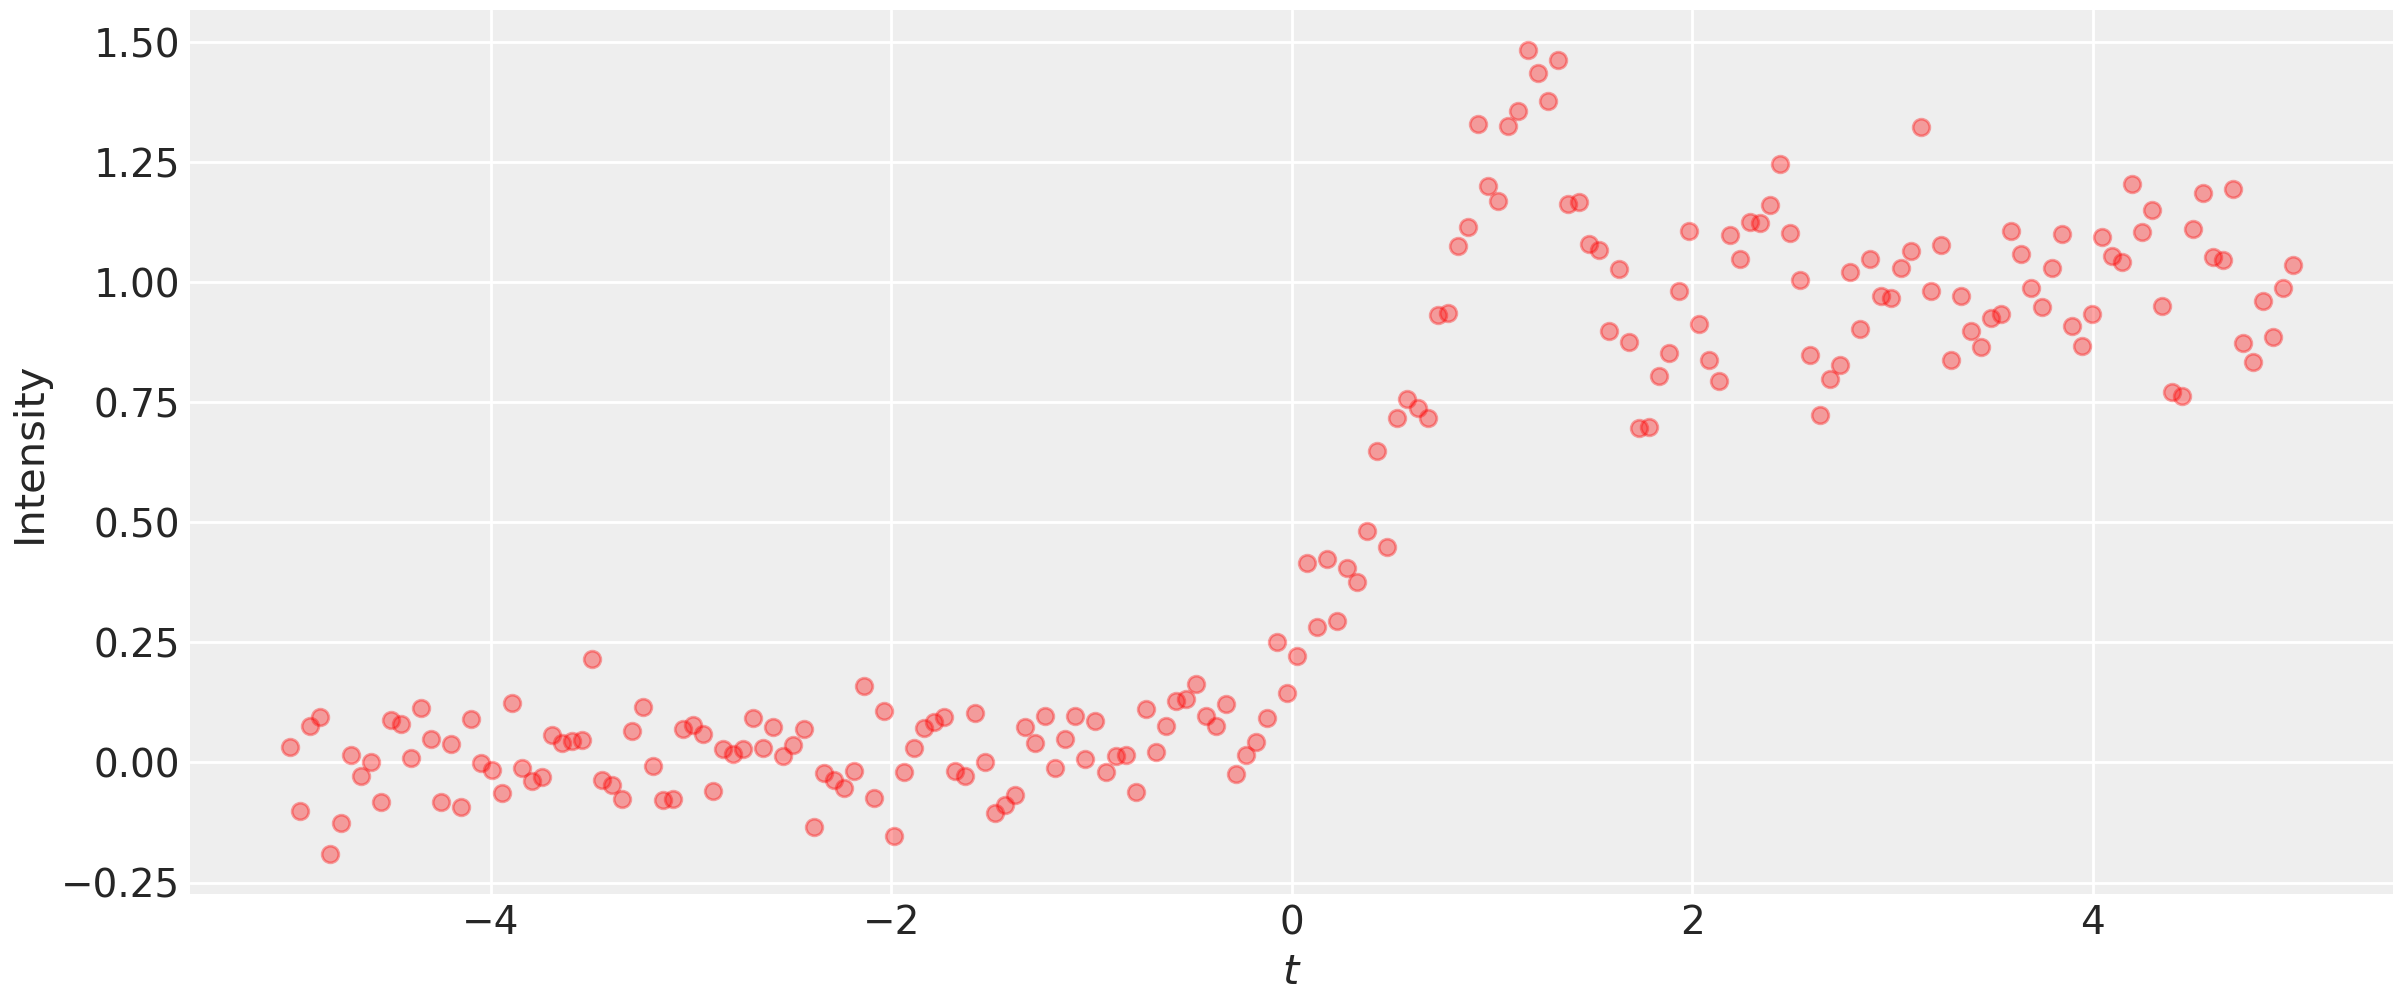

In [5]:
plt.figure(figsize = (12,5), facecolor='w')
plt.scatter(x_data, y_data_scaled, c='r', alpha=0.35)
plt.xlabel(r'$t$')
plt.ylabel('Intensity')

## *Fitting* dengan metode Bayesian menggunakan MCMC

##### Pembuatan model dan *bayesian inference*

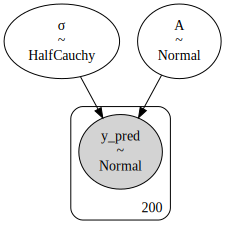

In [6]:
with pm.Model() as model_fresnel:
    amp = pm.Normal('A', mu=1., sigma=0.5)
    σ = pm.HalfCauchy('σ', beta=1.)
    mu = diffract(x_data, t0_true, amp, v_true) # model-nya (expected value)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=σ, observed=y_data_scaled) # likelihood-nya

pm.model_to_graphviz(model_fresnel)

In [7]:
with model_fresnel:
    # trace = pm.sample(1000, tune=1000, return_inferencedata=True)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [8]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.985,0.009,0.969,1.001,0.0,0.0,4191.0,2806.0,1.0
σ,0.088,0.004,0.080,0.096,0.0,0.0,4066.0,3087.0,1.0


Proses di atas digunakan untuk mendapatkan kembali parameter yang sudah ditentukan sebelumnya. Bandingkan hasil yang diperoleh dengan nilai awalnya ($A = 100, \sigma = 10$). <span style="color:red">(catatan: nilai $A$ sudah dinormalisasi ke 1.0)</span>

Text(0, 0.5, '$\\sigma$')

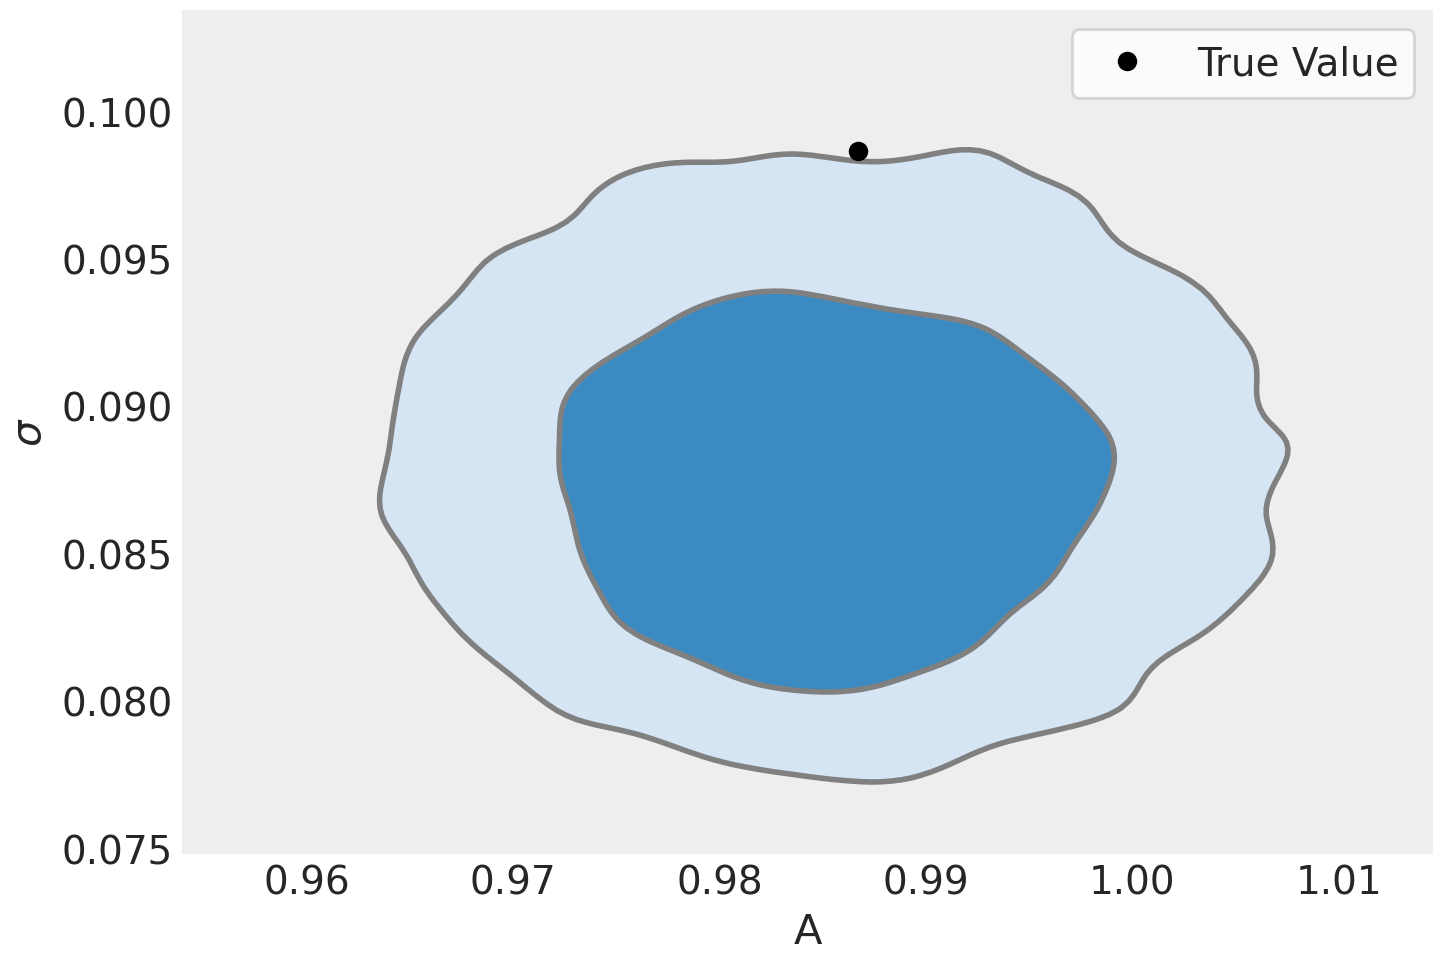

In [9]:
az.plot_kde(
    idata.posterior.stack(sample=("chain", "draw")).A.values,
    idata.posterior.stack(sample=("chain", "draw")).σ.values,
    contourf_kwargs={"cmap": "Blues"},
    hdi_probs = [0.68, 0.95]
)
plt.plot(A_true_scaled, σ_true_scaled, "ko", label="True Value")
plt.legend(facecolor="white", frameon=True);
plt.xlabel(r"A")
plt.ylabel(r"$\sigma$")

In [10]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot: title={'center': 'A'}>,
        <AxesSubplot: title={'center': 'A'}>],
       [<AxesSubplot: title={'center': 'σ'}>,
        <AxesSubplot: title={'center': 'σ'}>]], dtype=object)

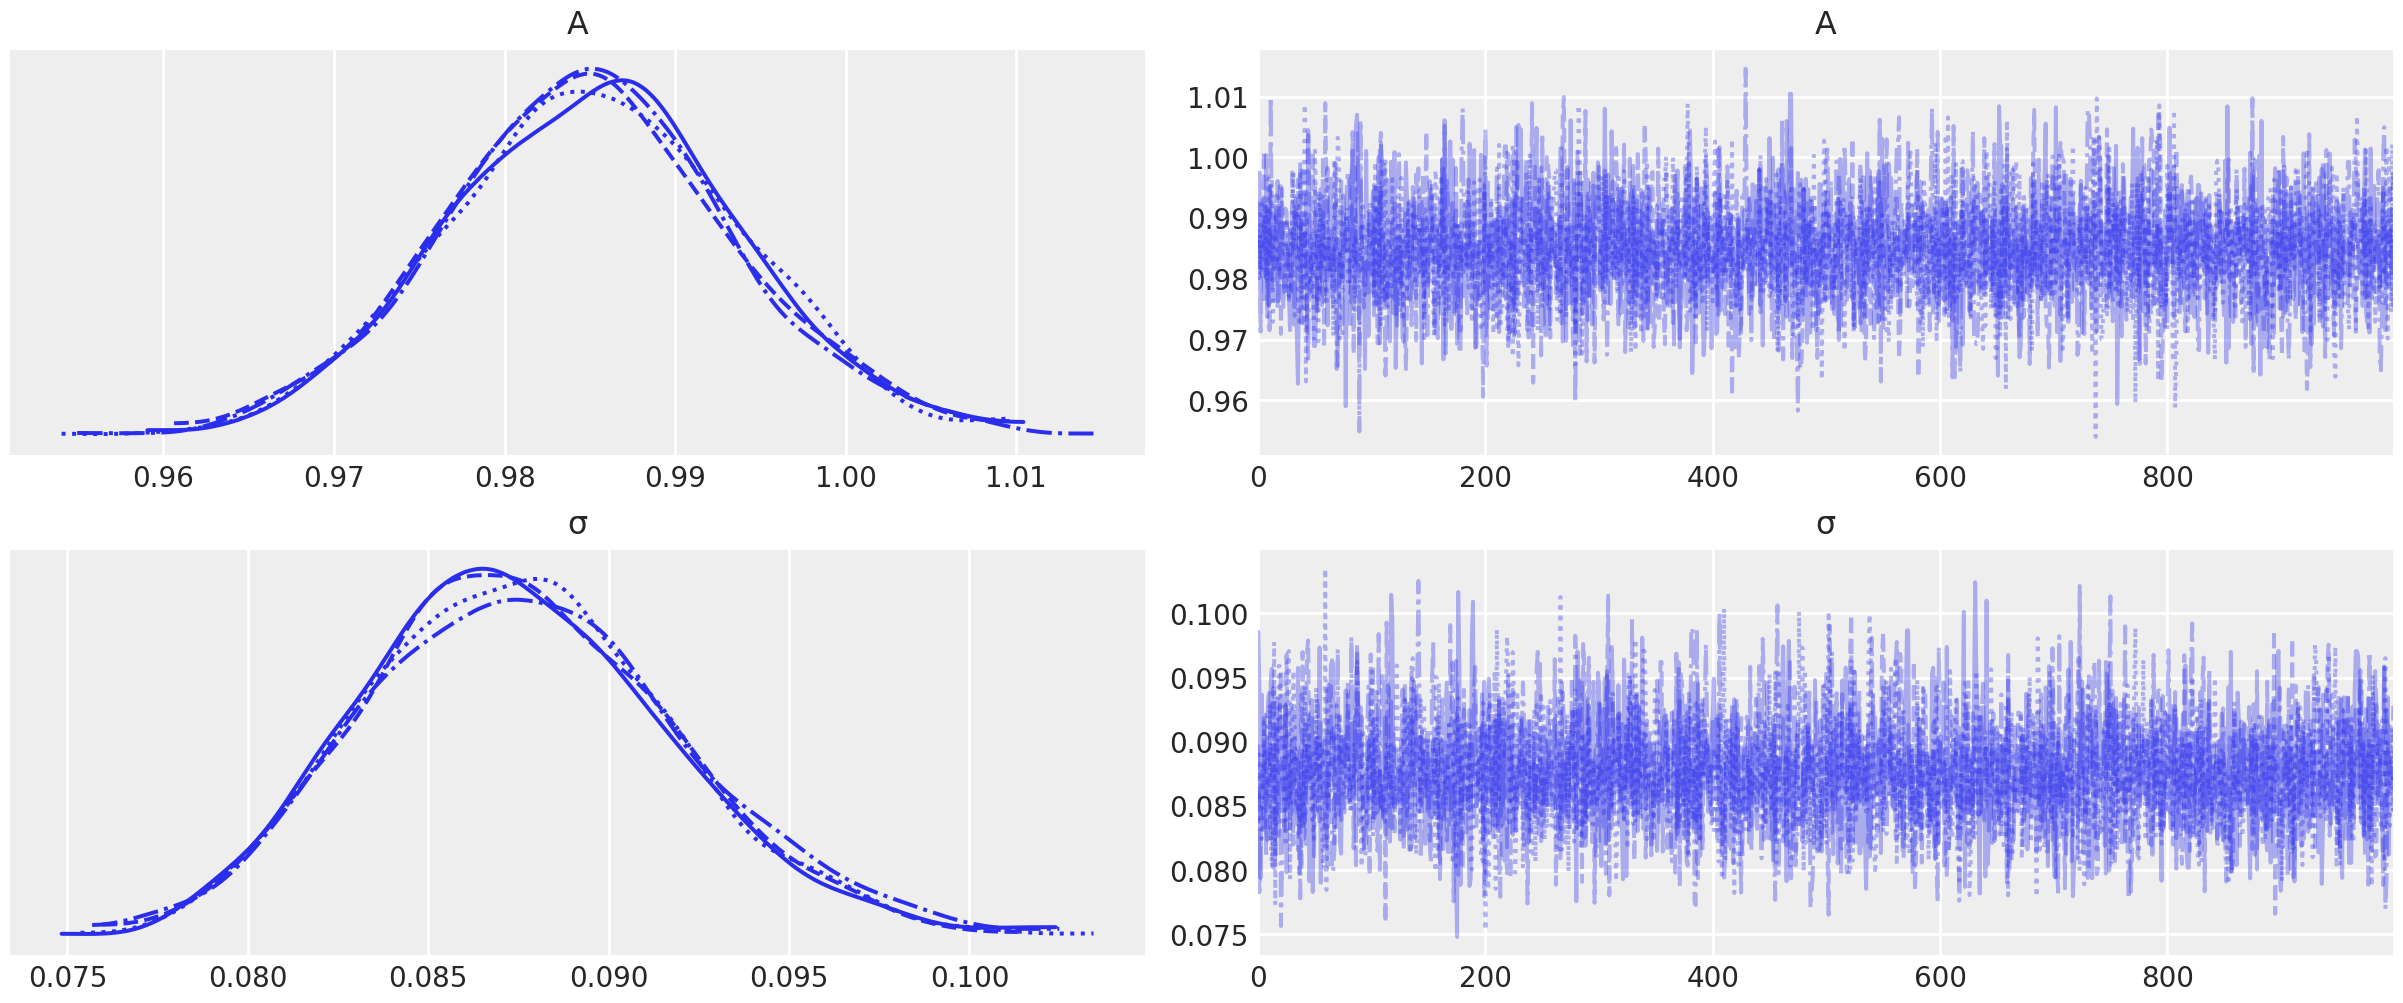

In [11]:
az.plot_trace(idata, figsize=(12,5))

### Posterior Predictive Check

In [12]:
with model_fresnel:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [y_pred]


In [13]:
idata.posterior_predictive

<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000, y_pred_dim_2: 200)
Coordinates:
  * chain         (chain) int32 0 1 2 3
  * draw          (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * y_pred_dim_2  (y_pred_dim_2) int32 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
Data variables:
    y_pred        (chain, draw, y_pred_dim_2) float64 0.07608 -0.1423 ... 1.181
Attributes:
    created_at:                 2022-11-22T14:05:08.311966
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  4.4.0

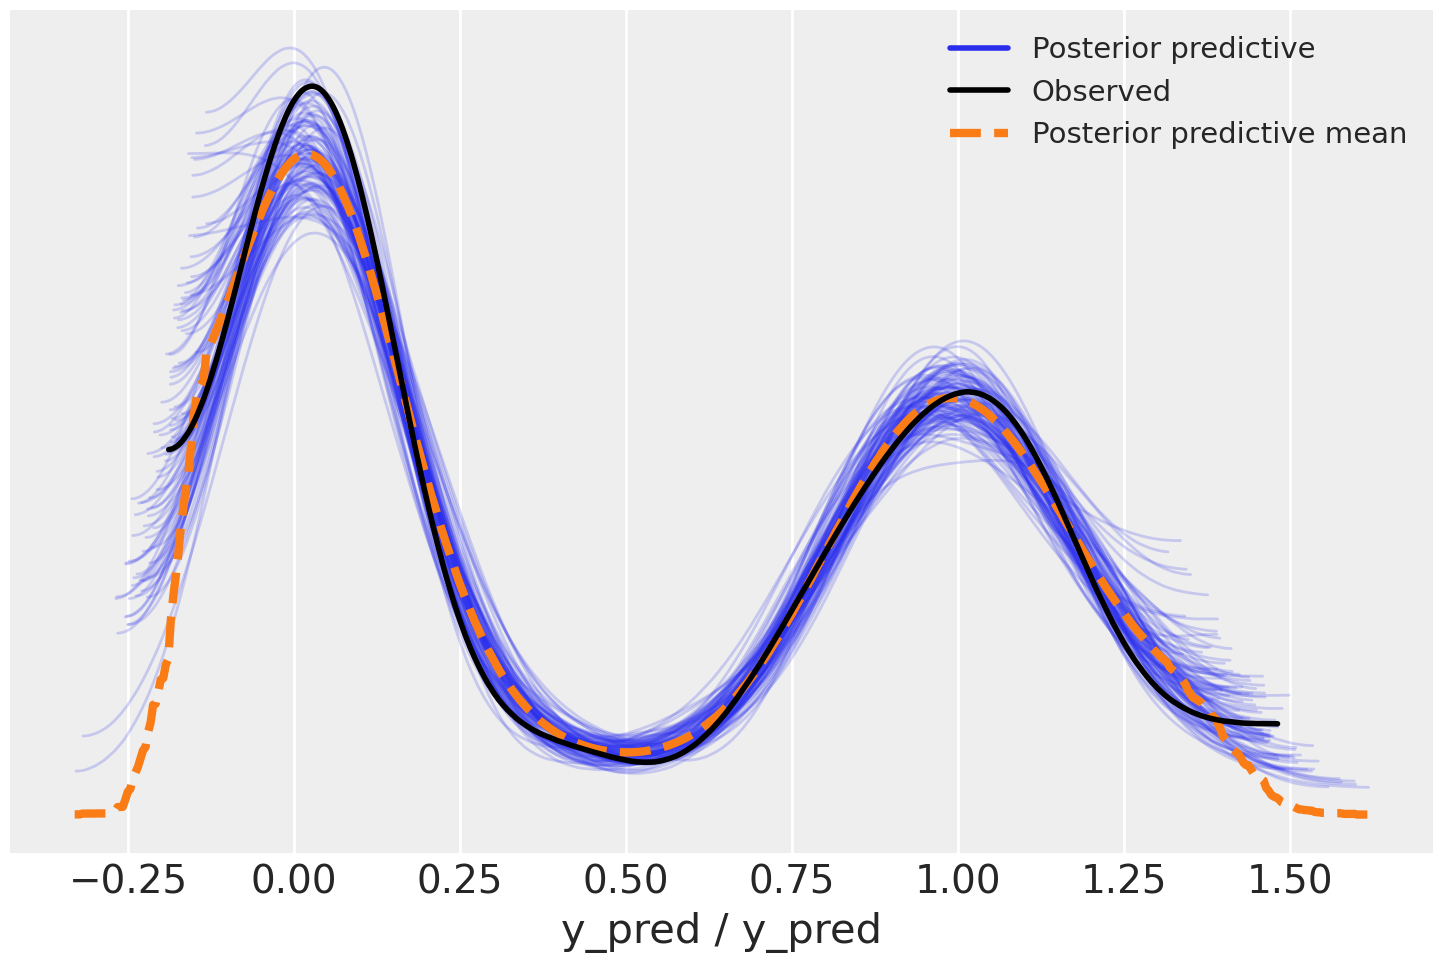

In [14]:
az.plot_ppc(idata, num_pp_samples=100);

In [15]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

## Hitung 2,5% dan 97.5% persentil dan plot bersama dengan data

In [16]:
idata_pp = idata.posterior_predictive

In [17]:
test = idata_pp.stack(sample=("chain", "draw"))
crit_l = np.percentile(test['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(test['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(test['y_pred'], axis=1) # Median

In [18]:
crit_l.shape

(200,)

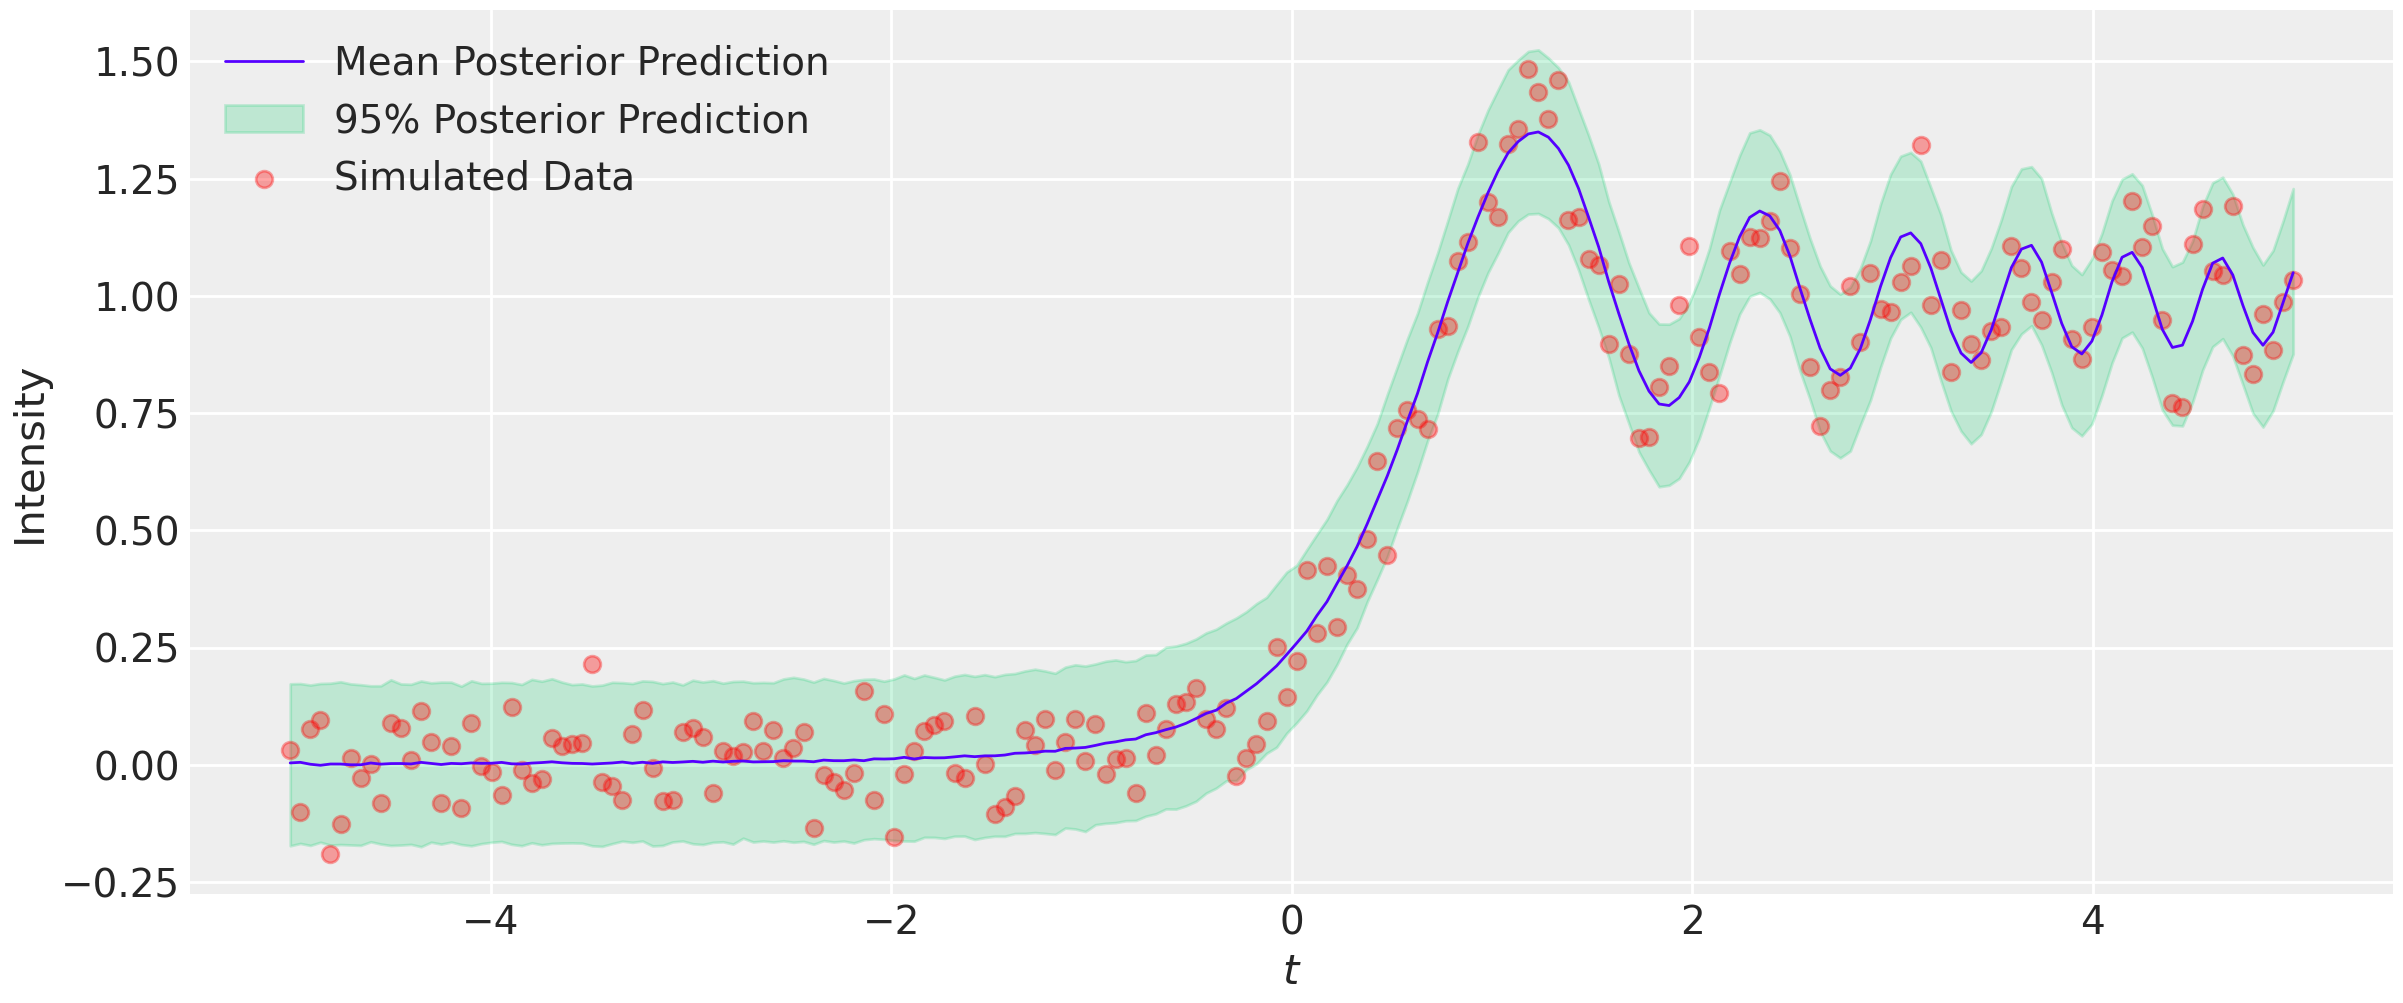

In [19]:
# with sns.plotting_context('talk', font_scale=1.2):
#     _, ax = plt.subplots(figsize=(14,6 ))
plt.figure(figsize=(12,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data, y_data_scaled, c='r', marker='o', alpha=0.35)
plt.xlabel(r'$t$')
plt.ylabel('Intensity')
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'])

## *Simulated data* untuk proses *disappearance* 

In [20]:
x_data_2 = np.linspace(-5, 5, 200)
σ_true = 10
A_true = 100
t0_true = 0
v_true = 1

y_data_2 = diffract(-x_data_2, t0_true, A_true, v_true)
y_data_2 = rng.normal(y_data_2, scale=σ_true)

y_data2_scaled = y_data_2 / (y_data_2.std()*2)

Text(0, 0.5, 'Intensity')

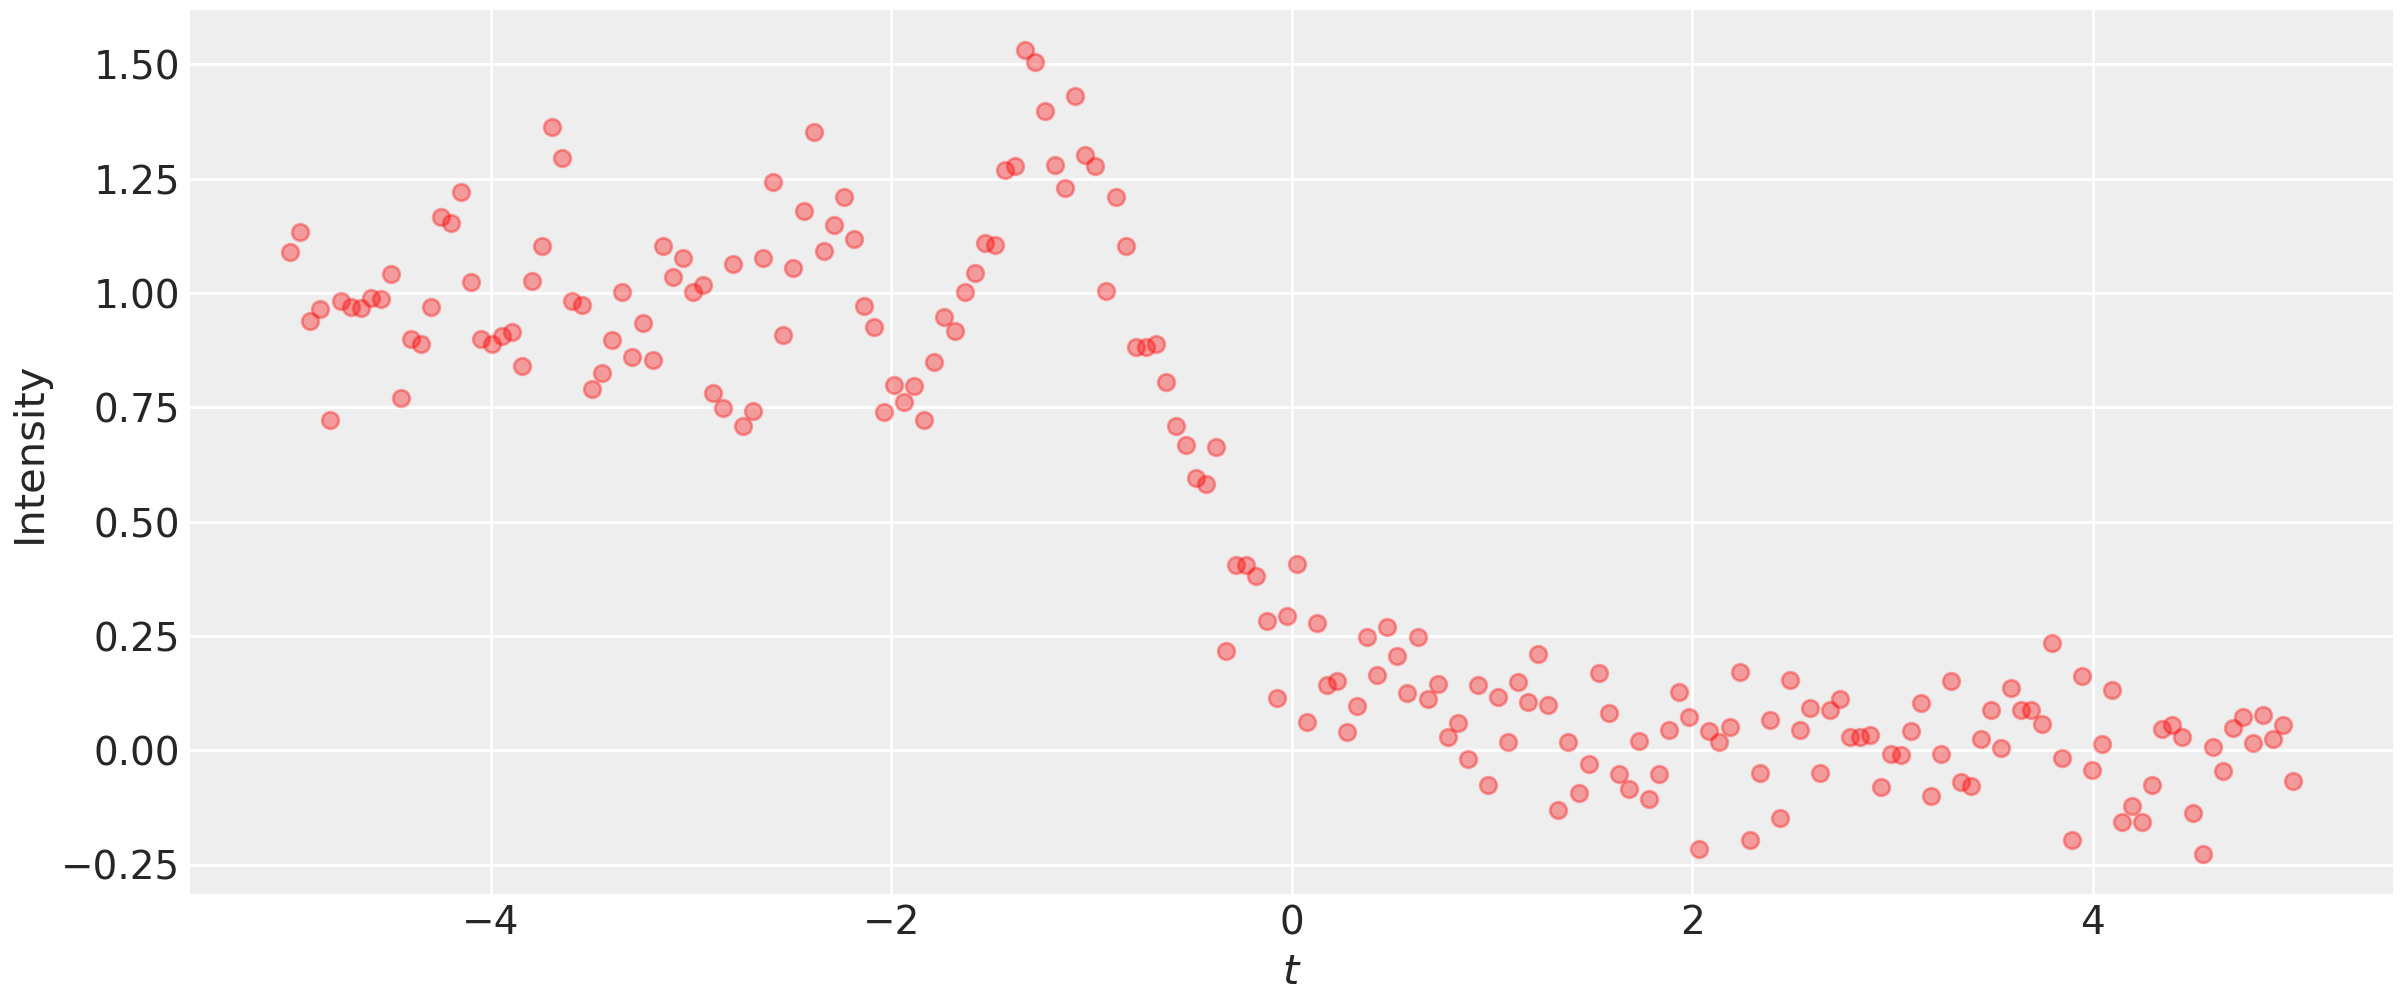

In [21]:
plt.figure(figsize = (12,5), facecolor='w')
plt.scatter(x_data_2, y_data2_scaled, c='r', alpha=0.35)
plt.xlabel(r'$t$')
plt.ylabel('Intensity')

In [22]:
with pm.Model() as model_fresnel_2:
    amp = pm.Normal('A', mu=0, sigma=10)
    σ = pm.HalfCauchy('σ', beta=1)
    mu = diffract(-x_data_2, t0_true, amp, v_true) # model-nya (expected value)
    y_pred_2 = pm.Normal('y_pred_2', mu=mu, sigma=σ, observed=y_data2_scaled) # likelihood-nya

In [23]:
with model_fresnel_2:
    idata = pm.sample()
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Sampling: [y_pred_2]


In [24]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.990,0.010,0.970,1.009,0.0,0.0,4275.0,3301.0,1.0
σ,0.102,0.005,0.092,0.111,0.0,0.0,4336.0,2946.0,1.0


Text(0, 0.5, '$\\sigma$')

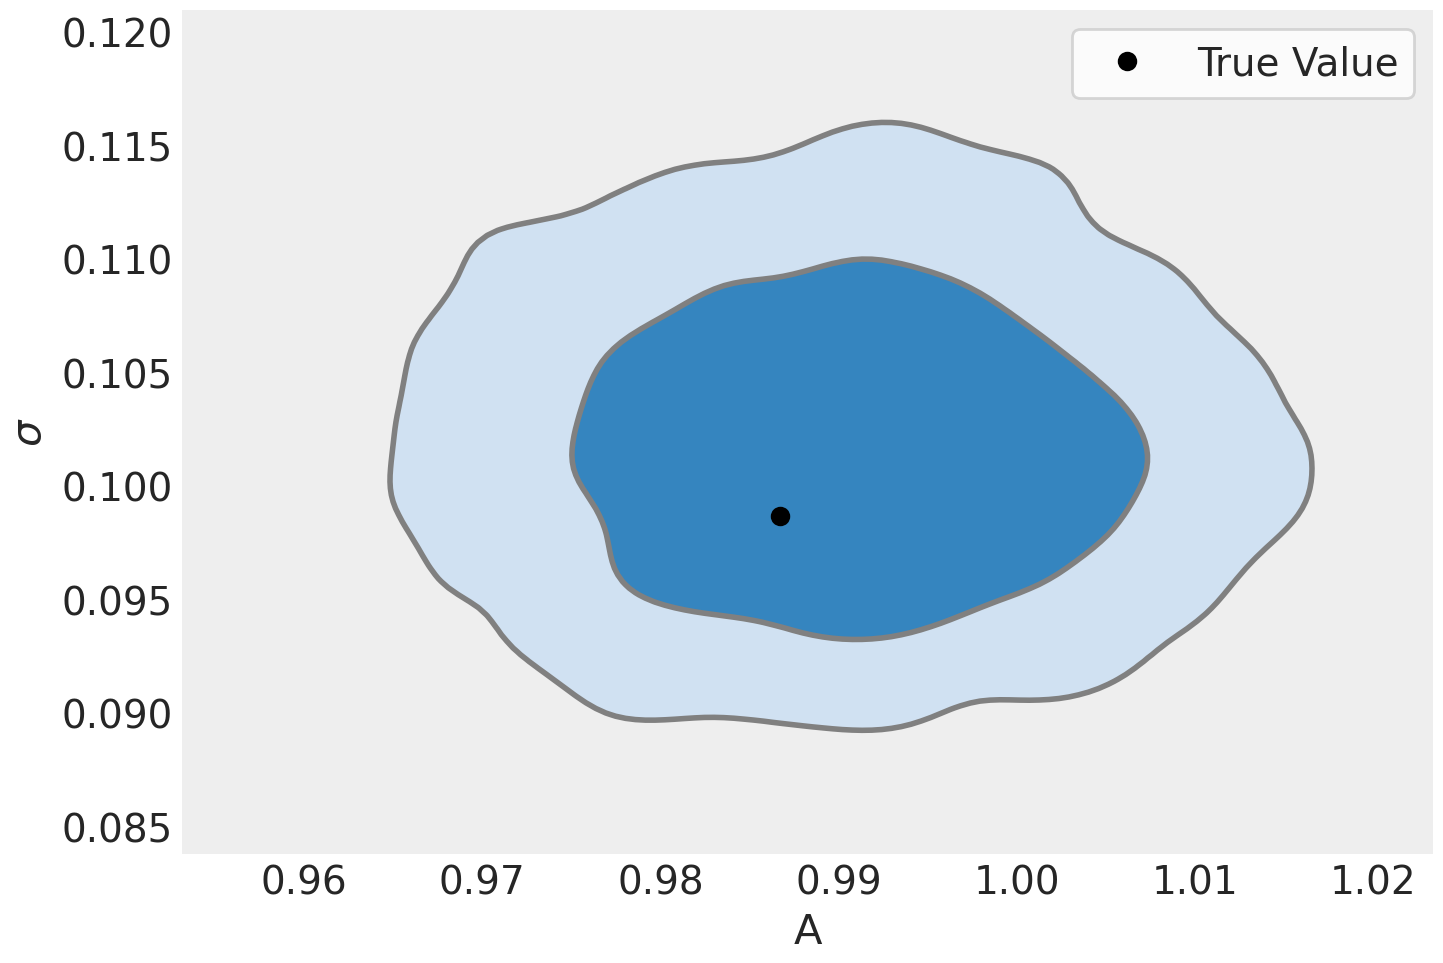

In [25]:
az.plot_kde(
    idata.posterior.stack(sample=("chain", "draw")).A.values,
    idata.posterior.stack(sample=("chain", "draw")).σ.values,
    contourf_kwargs={"cmap": "Blues"},
    hdi_probs = [0.68, 0.95]
)
plt.plot(A_true_scaled, σ_true_scaled, "ko", label="True Value")
plt.legend(facecolor="white", frameon=True);
plt.xlabel(r"A")
plt.ylabel(r"$\sigma$")

In [26]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [27]:
idata_pp2 = idata.posterior_predictive

In [28]:
test2 = idata_pp2.stack(sample=("chain", "draw"))
# test['y_pred'].shape
crit_l2 = np.percentile(test2['y_pred_2'], 2.5, axis=1)  # 2.5% persentil 
crit_u2 = np.percentile(test2['y_pred_2'], 97.5, axis=1)  # 97.5% persentil
mean_spp2 = np.mean(test2['y_pred_2'], axis=1) # Median

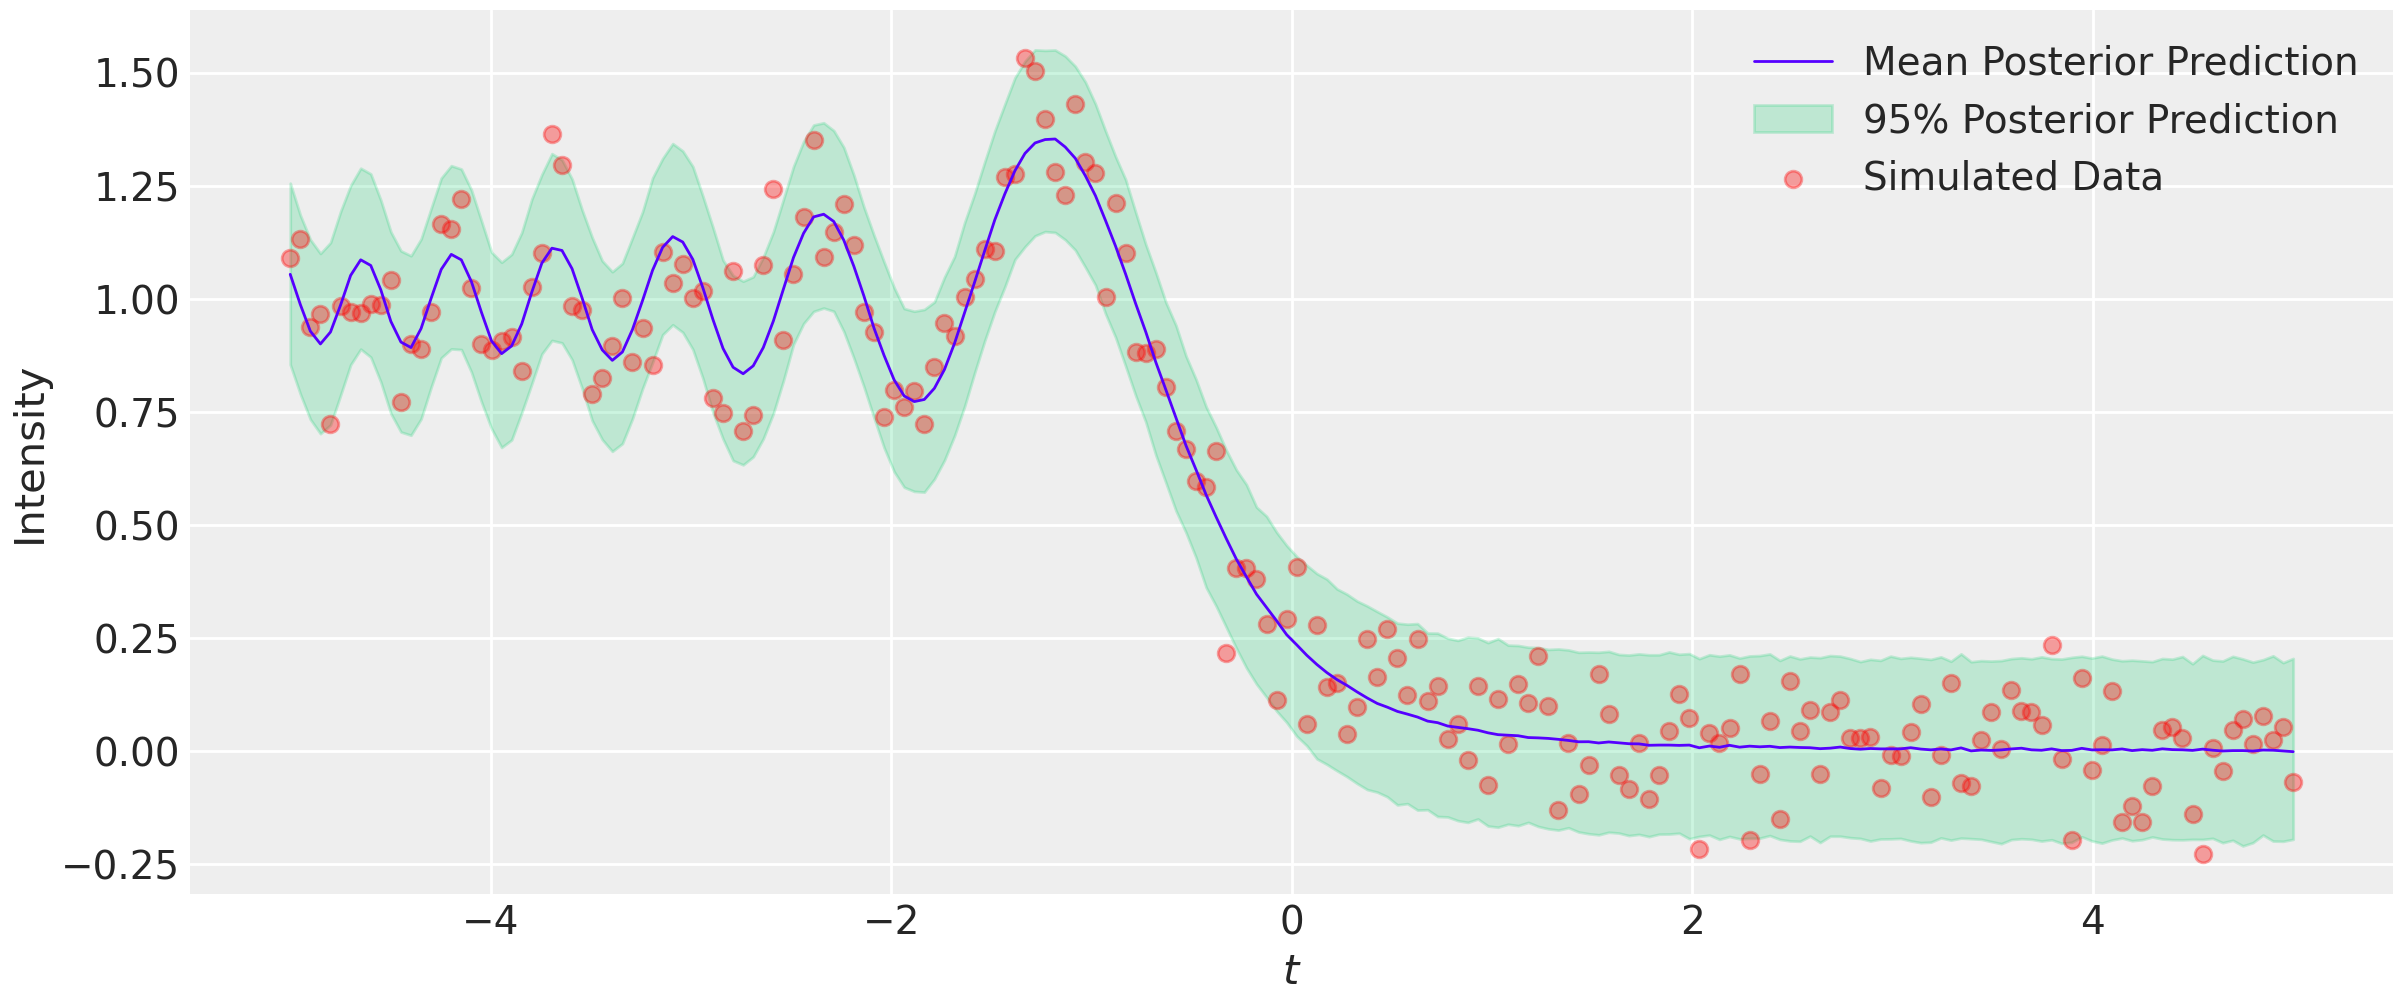

In [29]:
# with sns.plotting_context('talk', font_scale=1.2):
#     _, ax = plt.subplots(figsize=(14,6 ))
plt.figure(figsize=(12,5))
plt.plot(x_data_2, mean_spp2, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data_2, crit_l2, crit_u2, alpha=0.2, color="#00cc66")
plt.scatter(x_data_2, y_data2_scaled, c='r', marker='o', alpha=0.35)
plt.xlabel(r'$t$')
plt.ylabel('Intensity')
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'])

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Nov 22 2022

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

arviz     : 0.14.0
matplotlib: 3.6.2
pandas    : 1.5.1
numpy     : 1.23.5
scipy     : 1.9.3
pymc      : 4.4.0

Watermark: 2.3.1



### Abaikan code di bawah!

In [31]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [32]:
with model_fresnel_2:
    idata.extend(pm.sample_prior_predictive())

Sampling: [A, y_pred_2, σ]


In [33]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [34]:
prior = idata.prior
prior['σ'].shape

(1, 500)

In [35]:
x = np.linspace(-5, 5, 500)
y = diffract(-x, t0_true, prior['A'], v_true)

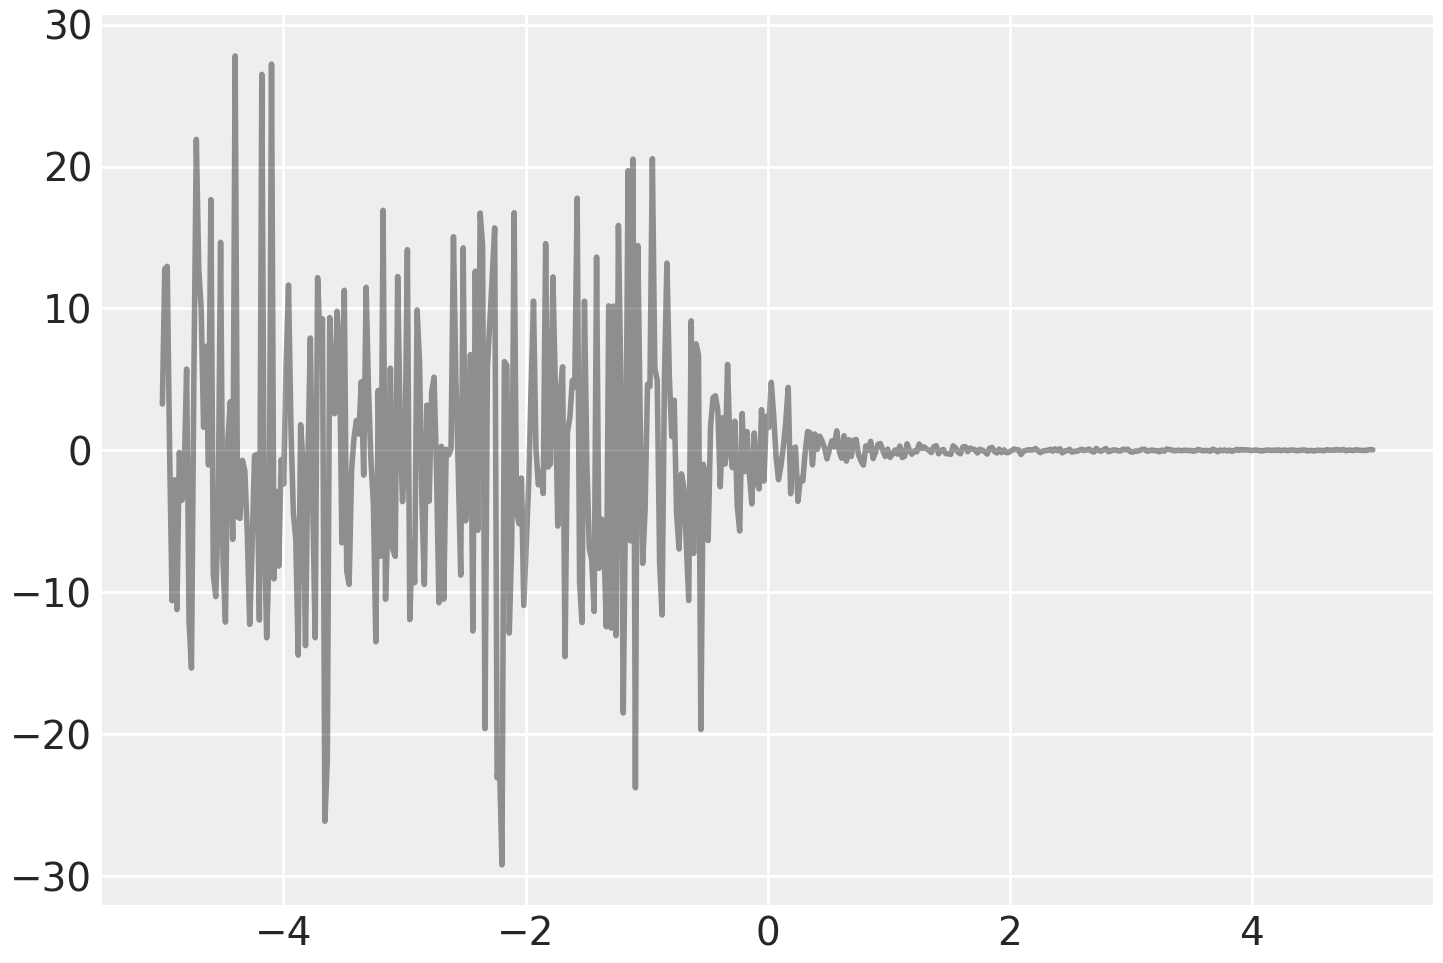

In [36]:
_, ax = plt.subplots()

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)